# Week 5 - Neural Network Build

Agenda
- Day 29 - 2-Layer NN: Forward, Backprop, Gradient Check
- Day 30 - Activations + Testing (ReLU & Sigmoid)
- Day 31 - PyTorch MLP Build (MNIST)
- Day 32 - Train on MNIST + Evaluate
- Day 33 - Optimizers: SGD vs Adam
- Day 34 - TensorBoard Logging
- Day 35 - Summary

## Day 29 — 2-Layer NN (NumPy): Forward, Backprop, Gradient Check

- Run Setup & Utilities cells (seed, helpers).
- Generate toy data (make_toy_data) and confirm class balance printed.
- Inspect the TwoLayerMLP class (forward/softmax/loss/backward).
- Run gradient check on a tiny batch.
    - Ensure max_rel_error ≤ ~1e-4 (ballpark).
- Train on toy data (train_numpy).
    - Loss curve decreases smoothly (plot rendered).
- Note any instability → lower lr or weight_scale.

Deliverables
- Screenshot (or saved image) of loss plot.
- Recorded max_rel_error and comments.

In [25]:
import numpy as np

# Toy data (replace with your X, y)
def make_toy_data(n=200):
    rng = np.random.default_rng(0) # randn is deprecated
    X0 = rng.normal([-1, -1], 0.55, size=(n//2, 2)) # normal(center, dev, output shape)
    X1 = rng.normal([1, 1], 0.55, size=(n//2, 2))
    X = np.vstack([X0, X1])
    y = np.concatenate([np.zeros(n//2, dtype=int), np.ones(n//2, dtype=int)])
    return X, y


In [26]:
class TwoLayerNN:
    def __init__(self, D, H, C, lr=0.1, weight_scale=0.01, seed=42, activation="relu"):
        # N, D = X.shape  # N=number of samples, D=number of features
        # H=number of hidden units, C=number of classes
        rng = np.random.default_rng(seed)
        self.W1 = weight_scale * rng.standard_normal((D, H))
        self.b1 = np.zeros((1, H))
        self.W2 = weight_scale * rng.standard_normal((H, C))
        self.b2 = np.zeros((1, C))   
        self.lr = 0.3
        self.activation = activation

    # 0) Activation (helper function)
    def _act(self, z):
        if self.activation == "relu": return np.maximum(0, z)  # ReLU
        elif self.activation == "sigmoid": return 1 / (1 + np.exp(-z))  # Sigmoid
        else: raise ValueError("Unsupported activation function")

    # 0) Derivative of activation (helper function)
    def _act_grad(self, z):
        if self.activation == "relu": return (z > 0).astype(z.dtype)  # ReLU derivative
        elif self.activation == "sigmoid": 
            sig = 1 / (1 + np.exp(-z))
            return sig * (1 - sig)  # Sigmoid derivative
        else: raise ValueError("Unsupported activation function")

    # 1) Forward 
    def forward(self, X):
        z1 = X @ self.W1 + self.b1  # (N, H)
        a1 = self._act(z1)  # ReLU activation (N, H)
        scores = a1 @ self.W2 + self.b2  # (N, C)
        cache = (X, z1, a1, scores)
        return scores, cache
    
    # 2) Softmax (helper function)
    @staticmethod
    def softmax(scores):
        scores_shifted = scores - scores.max(axis=1, keepdims=True)
        exp_scores = np.exp(scores_shifted)
        probs = exp_scores / exp_scores.sum(axis=1, keepdims=True) # (N, C)
        return probs

    # 3) Compute loss (cross-entropy) (helper function)
    # use log because high prob -> low penalty(loss); vice versa
    @staticmethod
    def cross_entropy_loss(probs, y):
        N = y.shape[0]
        correct_logprobs = -np.log(probs[range(N), y] + 1e-8)
        loss = correct_logprobs.mean()
        return loss

    # 4) Backpropagation
    def backward(self, probs, cache, y):

        X, z1, a1, scores = cache
        N = X.shape[0]

        dscores = probs
        dscores[range(N), y] -= 1
        dscores /= N # (N, C)

        dW2 = a1.T @ dscores # (H, C)
        db2 = dscores.sum(axis=0, keepdims=True) # (1, C)
        da1 = dscores @ self.W2.T # (N, H)

        dz1 = da1 * self._act_grad(z1) # ReLU backpropagation (N, H)

        dW1 = X.T @ dz1 # (D, H)
        db1 = dz1.sum(axis=0, keepdims=True) # (1, H)
        return dW1, db1, dW2, db2

    # 5) Parameter update
    def step(self, dW1, db1, dW2, db2):
        self.W1 -= self.lr * dW1
        self.b1 -= self.lr * db1
        self.W2 -= self.lr * dW2
        self.b2 -= self.lr * db2

    def predict(self, X): # helper for accuracy
        scores, _ = self.forward(X)
        probs = self.softmax(scores)
        return probs.argmax(axis=1)

    def train_step(self, X, y):
        scores, cache = self.forward(X)
        probs = self.softmax(scores)
        loss = self.cross_entropy_loss(probs, y)
        dW1, db1, dW2, db2 = self.backward(probs, cache, y)
        self.step(dW1, db1, dW2, db2)
        return loss



In [27]:


# Example usage
N, D, H, C = 5, 4, 10, 3
X = np.random.randn(N, D)
y = np.random.randint(C, size=N)

def run_experiment(activation):
    model = TwoLayerNN(D=D, H=H, C=C, lr=1e-1, activation=activation)

    for epoch in range(50):
        loss = model.train_step(X, y)
        if epoch % 10 == 0:
            preds = model.predict(X)
            acc = (preds == y).mean()
            print(f"Epoch {epoch}, Loss: {loss:.4f}, Accuracy: {acc:.4f}")
    return model

model_relu = run_experiment("relu")
model_sigmoid = run_experiment("sigmoid")


Epoch 0, Loss: 1.0986, Accuracy: 0.6000
Epoch 10, Loss: 0.8314, Accuracy: 0.6000
Epoch 20, Loss: 0.7267, Accuracy: 0.6000
Epoch 30, Loss: 0.4049, Accuracy: 1.0000
Epoch 40, Loss: 0.1665, Accuracy: 1.0000
Epoch 0, Loss: 1.0922, Accuracy: 0.6000
Epoch 10, Loss: 0.7269, Accuracy: 0.6000
Epoch 20, Loss: 0.6972, Accuracy: 0.6000
Epoch 30, Loss: 0.6818, Accuracy: 0.6000
Epoch 40, Loss: 0.6653, Accuracy: 0.6000


# Day 30 - Activations + Testing (ReLU & Sigmoid)
- Train the NumPy model with ReLU (record loss curve)
- Train the NumPy model with Sigmoid (record loss curve)
- Compare curves:
    - ReLU usually converges fater on this toy set
    - If Sigmoid is sluggish, consider smaller lr
- Deliverables
    - Two plots: ReLU loss, sigmoid loss
    - 2-3 bullet notes on observed differences

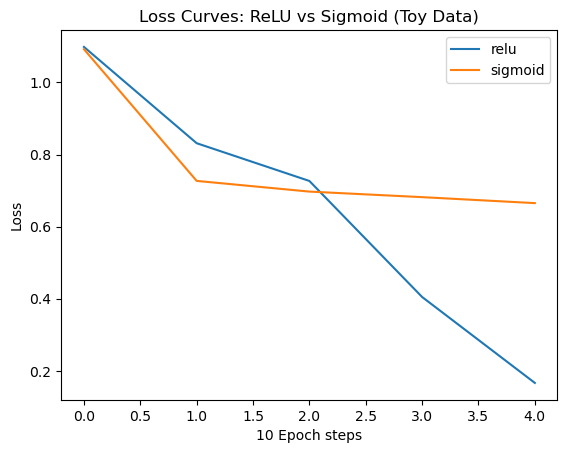

In [28]:
import matplotlib.pyplot as plt
loss_curves={}
for act in ["relu", "sigmoid"]:
    model = TwoLayerNN(D=D, H=H, C=C, lr=1e-1, activation=act)
    losses = []
    for epoch in range(50):
        loss = model.train_step(X, y)
        if epoch % 10 == 0:
            losses.append(loss) 
    loss_curves[act] = losses

def plot_series(data_dict, title="", xlabel="", ylabel=""): 
    for label, series in data_dict.items():
        plt.plot(series, label=label)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.legend()
    plt.show()

plot_series(loss_curves, title="Loss Curves: ReLU vs Sigmoid (Toy Data)", xlabel="10 Epoch steps", ylabel="Loss")

- On this toy run, ReLU learns faster and ends with a lower loss than Sigmoid. Sigmoid improves a bit, then kind of stalls. 

- ReLU trends to give stronger gradients in the active region (z>0), so learning keeps going. 
- Sigmoid can saturate (outputs very close to 0 or 1), where gradients become tiny -> updates get small -> the loss curve fattens

## Day 31 — PyTorch MLP Build (MNIST)
- Run MNIST transforms & dataset cell (downloads if needed).
- Create train/val split + DataLoaders.
- Inspect MNISTMLP architecture (Flatten → Linear → ReLU → Linear → ReLU → Linear).
- Initialize model on DEVICE and count parameters (printed).

Deliverables
- Param count noted.
- Brief rationale for chosen hidden size (e.g., 256).

In [29]:
from pathlib import Path
import torch
from torch import nn
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms

#Reproducibility
SEED = 42
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
np.random.seed(SEED)    

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
DEVICE

def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)


In [30]:
# calculate mean and std
root = "./data"
# 1. Temporary transform; only ToTensor(no Normalize yet)
transform_no_norm = transforms.ToTensor()
train_raw = datasets.MNIST(root=root, train=True, download=True, transform=transform_no_norm)

# 2. Put all training images into one big batch (60000)
loader = DataLoader(train_raw, batch_size=len(train_raw), shuffle=False)
imgs, _ = next(iter(loader))  # imgs shape: (60000, 1, 28, 28)

# 3. Compute mean and std over all pixels
mean = imgs.mean()
std = imgs.std()

print("Mean:", mean.item())
print("Std:", std.item())


Mean: 0.13066048920154572
Std: 0.30810782313346863


In [31]:
# Use those values in your real transform
MINST_MEAN = (mean.item(),)  # single value tuple for grayscale
MINST_STD = (std.item(),)    # single value tuple for grayscale

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(MINST_MEAN, MINST_STD)
])

train_dataset = datasets.MNIST(root=root, train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root=root, train=False, download=True, transform=transform)

print(len(train_dataset), len(test_dataset))  #60000 10000


60000 10000


In [32]:
# Train/validation split from training set
val_ratio = 0.1
n_val = int(len(train_dataset) * val_ratio)
n_train = len(train_dataset) - n_val
train_data, val_data = random_split(train_dataset, [n_train, n_val], generator=torch.Generator().manual_seed(SEED))

BATCH_SIZE = 128
train_loader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_data, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

n_train, n_val, len(test_loader.dataset)

(54000, 6000, 10000)

In [33]:
# Model building
class MNISTMLP(nn.Module):
    def __init__(self, in_dim=28*28, hidden_dim=256, num_classes=10):
        super().__init__()
        self.net = nn.Sequential(
            nn.Flatten(), 
            nn.Linear(in_dim, hidden_dim), 
            nn.ReLU(), 
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(), 
            nn.Linear(hidden_dim, num_classes)
        )
    def forward(self, x):
        return self.net(x)
    
model = MNISTMLP().to(DEVICE)
sum(p.numel() for p in model.parameters())

269322

In [34]:
def train_one_epoch(model, loader, optimizer, criterion):
    model.train()
    total_loss, total_correct, total_count = 0.0, 0, 0
    for xb, yb in loader:
        xb, yb = xb.to(DEVICE), yb.to(DEVICE)
        optimizer.zero_grad() #reset gradients
        logits = model(xb)
        loss = criterion(logits, yb)
        loss.backward()
        optimizer.step() # update parameters, eg. W = W-lr * dW
        total_loss += loss.item() * xb.size(0)
        total_correct += (logits.argmax(dim=1) == yb).sum().item()
        total_count += xb.size(0)
    return total_loss / total_count, total_correct / total_count # average loss and accuracy    
    

In [35]:
@torch.no_grad() #inside this block, no gradients will be computed
def evaluate(model, loader, criterion):
    model.eval()
    total_loss, total_correct, total_count = 0.0, 0, 0
    for xb, yb in loader:
        xb, yb = xb.to(DEVICE), yb.to(DEVICE)
        logits = model(xb)
        loss = criterion(logits, yb)
        total_loss += loss.item() * xb.size(0)
        total_correct += (logits.argmax(dim=1) == yb).sum().item()
        total_count += xb.size(0)
    return total_loss / total_count, total_correct / total_count

## Day 32 — Train on MNIST + Evaluate
- Train baseline with SGD(lr=0.1) for EPOCHS=5.
    - See printed epoch logs (train/val loss & val acc).
- Plot:
    - Training loss
    - Validation loss
    - Validation accuracy
- Evaluate on test set; record test_loss, test_acc.
- Save weights to mnist_mlp.pth.

Quality checks
- Val acc typically ≥ 0.95 by ~5 epochs (ballpark on CPU; may vary).
- Loss curves not diverging.

Deliverables
- Three plots + test metrics.
- mnist_mlp.pth exists in working dir.

Epoch 1/5 | Train Loss 0.0485 | Val Loss 0.0844 | Val Acc 0.9730
Epoch 2/5 | Train Loss 0.0390 | Val Loss 0.0779 | Val Acc 0.9775
Epoch 3/5 | Train Loss 0.0309 | Val Loss 0.0801 | Val Acc 0.9745
Epoch 4/5 | Train Loss 0.0251 | Val Loss 0.0819 | Val Acc 0.9763
Epoch 5/5 | Train Loss 0.0199 | Val Loss 0.0762 | Val Acc 0.9755


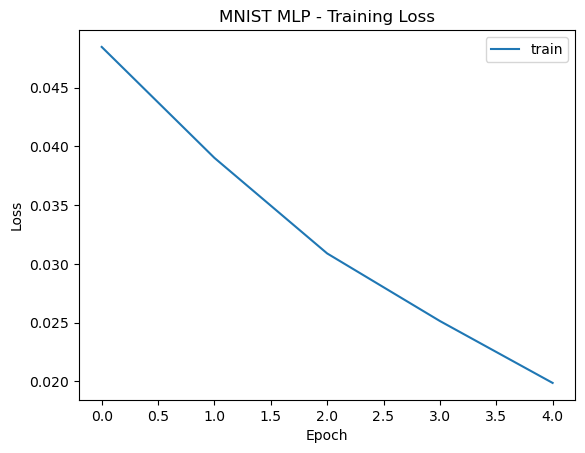

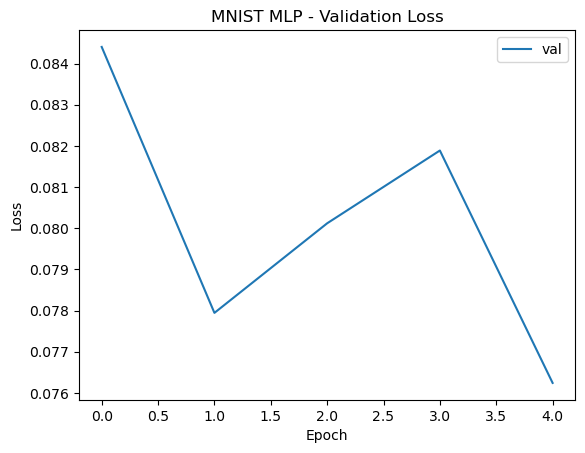

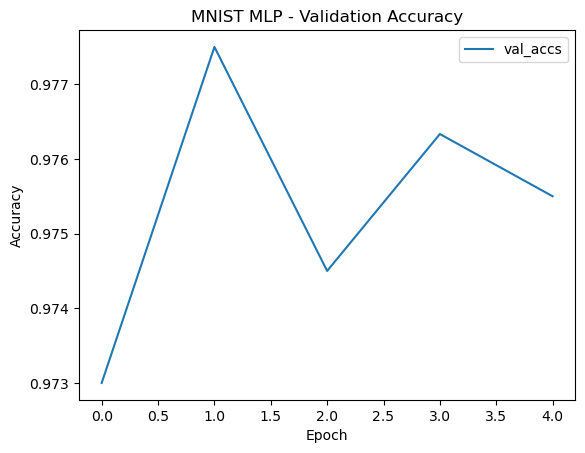

In [39]:
# Baseline training
EPOCHS = 5
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.1)

train_losses, val_losses, val_accs = [], [], []
for epoch in range(1, EPOCHS+1):
    tr_loss, tr_acc = train_one_epoch(model, train_loader, optimizer, criterion)
    va_loss, va_acc = evaluate(model, val_loader, criterion)
    train_losses.append(tr_loss)
    val_losses.append(va_loss)
    val_accs.append(va_acc)
    print(f"Epoch {epoch}/{EPOCHS} | Train Loss {tr_loss:.4f} | Val Loss {va_loss:.4f} | Val Acc {va_acc:.4f}")

plot_series({"train": train_losses}, title="MNIST MLP - Training Loss", xlabel="Epoch", ylabel="Loss")
plot_series({"val": val_losses}, title="MNIST MLP - Validation Loss", xlabel="Epoch", ylabel="Loss")
plot_series({"val_accs": val_accs}, title="MNIST MLP - Validation Accuracy", xlabel="Epoch", ylabel="Accuracy")

## Day 33 — Optimizers: SGD vs Adam
- Run comparison helper train_model_with_optimizer.
- Train SGD model (e.g., lr=0.1, 5 epochs) → record val loss/acc.
- Train Adam model (e.g., lr=1e-3, 5 epochs) → record val loss/acc.
- Plot four figures:
    - Val loss — SGD
    - Val loss — Adam
    - Val acc — SGD
    - Val acc — Adam
- Summarize:
    - Which optimizer reached lower val loss faster?
    - Which one achieved higher val acc in 5 epochs?

Deliverables
- Plots + 3 short bullets comparing speed/stability/final acc.

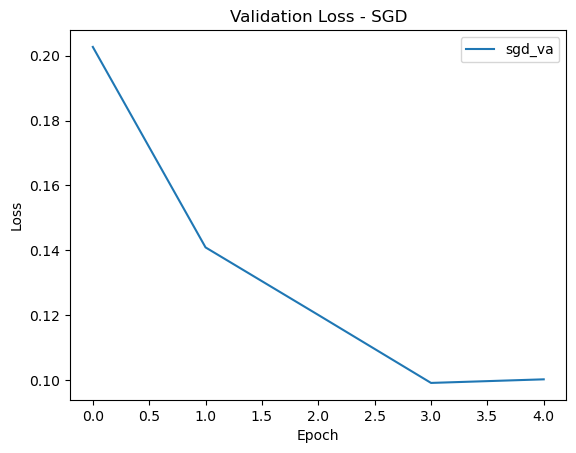

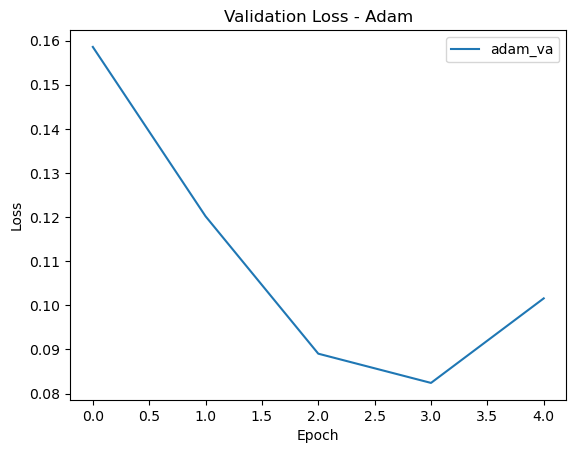

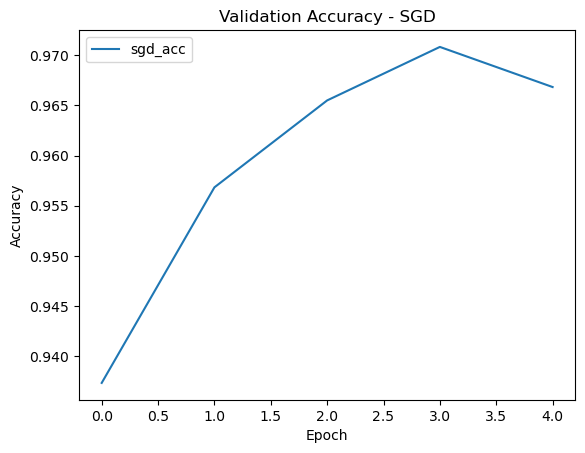

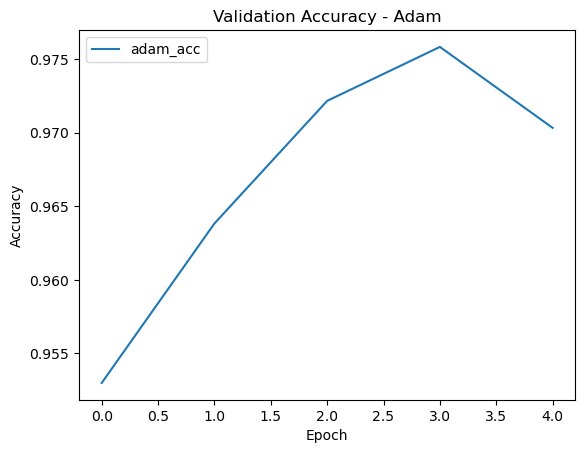

In [41]:
def train_model_with_optimizer(optimizer_name="SGD", epochs=5, lr=0.0001):
    m = MNISTMLP().to(DEVICE)
    criterion = nn.CrossEntropyLoss()
    if optimizer_name.lower() == "sgd": opt = torch.optim.SGD(m.parameters(), lr=lr)
    elif optimizer_name.lower() == "adam": opt = torch.optim.Adam(m.parameters(), lr=lr)
    else: raise ValueError("Unsupported optimizer")

    tr_losses, va_losses, va_accs = [], [], []
    for ep in range(1, epochs+1):
        tr_loss, _ = train_one_epoch(m, train_loader, opt, criterion)
        va_loss, va_acc = evaluate(m, val_loader, criterion)
        tr_losses.append(tr_loss); va_losses.append(va_loss); va_accs.append(va_acc)
    return tr_losses, va_losses, va_accs

sgd_tr, sgd_va, sgd_acc = train_model_with_optimizer("SGD", epochs=5, lr=0.1)
adam_tr, adam_va, adam_acc = train_model_with_optimizer("Adam", epochs=5, lr=0.001)

# Plot separately per rule (single plot per figure)
plot_series({"sgd_va": sgd_va}, title="Validation Loss - SGD", xlabel="Epoch", ylabel="Loss")
plot_series({"adam_va": adam_va}, title="Validation Loss - Adam", xlabel="Epoch", ylabel="Loss")
plot_series({"sgd_acc": sgd_acc}, title="Validation Accuracy - SGD", xlabel="Epoch", ylabel="Accuracy")
plot_series({"adam_acc": adam_acc}, title="Validation Accuracy - Adam", xlabel="Epoch", ylabel="Accuracy")


“Adam converged faster and to a slightly better solution than SGD for my MLP on MNIST.”

## Day 34 — TensorBoard Logging
- Create SummaryWriter("runs/mnist_mlp").
- Train 3 epochs with Adam while logging:
    - Loss/train logged each step.
    - Loss/val + Accuracy/val logged each epoch.
    - Graph added with a dummy input.
- Launch locally:
    - tensorboard --logdir runs --port 6006
    - Open http://localhost:6006
- Inspect:
    - Scalars tab shows curves.
    - Graph tab shows model graph.

Deliverables
- Screenshot of TensorBoard scalars.
- 1–2 notes on any over/underfitting hints seen.

In [43]:
from torch.utils.tensorboard import SummaryWriter

log_dir = "runs/mnist_mlp"
writer = SummaryWriter(log_dir=log_dir)

model_tb = MNISTMLP().to(DEVICE)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_tb.parameters(), lr=0.001)

EPOCHS_TB = 3
global_step = 0
for epoch in range(1, EPOCHS_TB+1):
    model_tb.train()
    for xb, yb in train_loader:
        xb, yb = xb.to(DEVICE), yb.to(DEVICE)
        optimizer.zero_grad()
        logits = model_tb(xb)
        loss = criterion(logits, yb)
        loss.backward()
        optimizer.step() #update parameters

        #Log training loss
        writer.add_scalar("Loss/Train", loss.item(), global_step)
        global_step += 1

    # Log validation metrics per epoch
    val_loss, val_acc = evaluate(model_tb, val_loader, criterion)
    writer.add_scalar("Loss/Val", val_loss, epoch)
    writer.add_scalar("Accuracy/Val", val_acc, epoch)

# Optionally, and the computational graph
example_input = torch.randn(1, 1, 28, 28).to(DEVICE)
writer.add_graph(model_tb, example_input)
writer.flush()
writer.close()

print(f"TensorBoard logs saved to {log_dir}. Run 'tensorboard --logdir={log_dir}' to view.")


TensorBoard logs saved to runs/mnist_mlp. Run 'tensorboard --logdir=runs/mnist_mlp' to view.


In [48]:
%reload_ext tensorboard
%tensorboard --logdir=runs

Reusing TensorBoard on port 6007 (pid 8168), started 0:05:42 ago. (Use '!kill 8168' to kill it.)

## Day 35 — Weekly Summary & README

- Write Key learnings (3–6 bullets).
- Add Next ideas you plan to try (BatchNorm/Dropout/CNN/etc.).
- Export/share:
    - Save notebook cleanly (restart & run all if possible).
    - Optional: Export to HTML/Markdown for GitHub README.

Deliverables
- Completed summary section in the notebook.
- Short README snippet ready to paste in your repo.

Here is a clean summary you can paste into your notes.

---

### Key learnings from the SGD vs Adam experiment

* Both **SGD and Adam successfully learn**: validation loss decreases and validation accuracy increases in the first epochs, so the training loop and evaluation code are working as expected.
* **Adam reaches better validation performance** than SGD: it achieves both a lower minimum validation loss and a slightly higher peak validation accuracy.
* For **both optimizers, epoch 3 is the best point**: validation loss is lowest and validation accuracy is highest there; continuing to epoch 4 slightly hurts performance.
* The small **increase in validation loss and drop in accuracy after epoch 3** is an early sign of **overfitting** or at least “no further generalization gain.”
* This experiment shows the value of **tracking validation metrics and using early stopping** (stop training when validation performance stops improving).

---

### Next ideas to try

You can treat these as mini-experiments:

* **Increase epochs with early stopping**
  Train longer (e.g., 20–30 epochs) but stop when validation loss has not improved for N epochs. Compare “best” validation accuracy vs fixed 5 epochs.

* **Play with learning rate and batch size**
  Try smaller/larger learning rates for both SGD and Adam, and batch sizes like 32, 64, 256. Watch how the curves change (stability vs speed).

* **Add Regularization**

  * **Dropout** between linear layers (e.g., p=0.2–0.5) and see if it reduces overfitting and improves validation accuracy.
  * **Weight decay (L2 regularization)** in the optimizer and compare curves.

* **Add Batch Normalization**

  * Insert `nn.BatchNorm1d(hidden)` between linear and activation layers in your MLP.
  * Observe whether training becomes faster / more stable and how validation metrics change.

* **Try a deeper or wider MLP**

  * More hidden units (e.g., 512) or more layers, then check if capacity helps or increases overfitting.

* **Move from MLP to CNN**

  * Implement a simple CNN (Conv → ReLU → Pool → Conv → ReLU → Flatten → Linear).
  * Compare its validation accuracy and loss curves to the MLP; you should see a noticeable jump in performance on MNIST.

* **Compare optimizers in a table**

  * For each setup (MLP, CNN), log: best val loss, best val acc, epoch of best model, and training time per epoch for SGD vs Adam (and later RMSProp, Momentum, etc.).

If you tell me which of these you want to run next, I can help you design the exact code changes and what to log/plot.


## Optional “Gotchas” Checklist (any day)
- If loss is NaN, lower lr or increase weight_scale stability.
- If gradients explode/vanish, try ReLU, smaller depth, or normalize inputs.
- Ensure model.eval() + torch.no_grad() for evaluation.
- Confirm device usage: tensors and model on same DEVICE.
- For reproducibility, re-run seed cell if you changed settings.